<a href="https://colab.research.google.com/github/imarosan/Resume/blob/main/PredictingHousePrices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Part 1: Exploring Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [ ]:
train = pd.read_csv('housing_train.csv')
test_df = pd.read_csv('housing_test.csv')

In [ ]:
train.info()

In [ ]:
test_df.info()

<ipython-input-5-38bf81192dc7>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['SalePrice'])


<Axes: xlabel='SalePrice', ylabel='Density'>

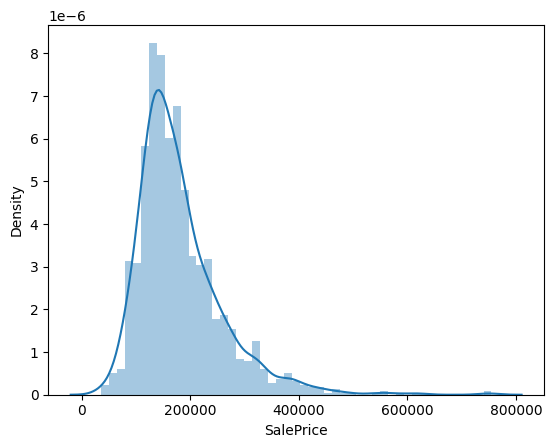

In [ ]:
# Distribution Plot of Train DF
sns.distplot(train['SalePrice'])

<ipython-input-6-87d01865abfb>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['SalePrice'])


<Axes: xlabel='SalePrice', ylabel='Density'>

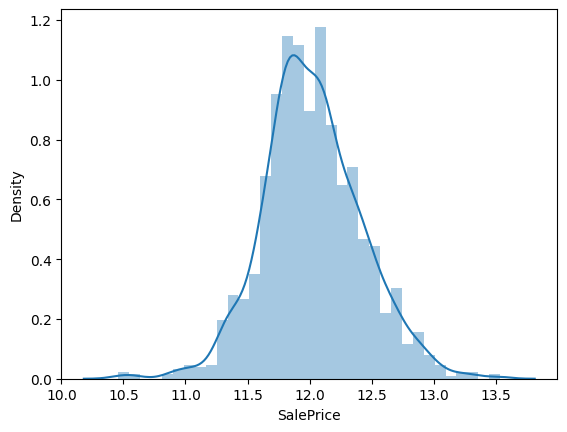

In [ ]:
#Distribution plot of train df after normalizing
train_df = train.copy()
train_df.SalePrice = np.log1p(train_df.SalePrice)
sns.distplot(train_df['SalePrice'])

#Part 2: Cleaning Data

In [ ]:
# drop columns in train data with not enough data(less than 50%) or not important (ID)
train_df=train_df.drop("Id",axis=1)
train_df=train_df.drop("Alley",axis=1)
train_df=train_df.drop("PoolQC",axis=1)
train_df=train_df.drop("Fence",axis=1)
train_df=train_df.drop("MiscFeature",axis=1)
# drop columns from test that were dropped in train
test_df=test_df.drop("Alley",axis=1)
test_df=test_df.drop("PoolQC",axis=1)
test_df=test_df.drop("Fence",axis=1)
test_df=test_df.drop("MiscFeature",axis=1)

In [ ]:
# filling missing values
for i in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual',
            'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
            'FireplaceQu','MasVnrType','Utilities']:
   train_df[i] = train_df[i].fillna('None')
# Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string
common_vars = ['Exterior1st','Exterior2nd','SaleType','Electrical','KitchenQual']
for i in common_vars:
    train_df[i] = train_df[i].fillna(train_df[i].mode()[0])
# 'RL' is by far the most common value. So we can fill in missing values with 'RL'
train_df['MSZoning'] = train_df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
# Replacing missing data with 0 (Since No garage = no cars in such garage.)
for i in ('GarageYrBlt', 'GarageArea', 'GarageCars','MasVnrArea','BsmtFinSF1','BsmtFinSF2',
            'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BsmtUnfSF','TotalBsmtSF'):
    train_df[i] = train_df[i].fillna(0)
# group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
train_df['LotFrontage'] = train_df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
print('Features size:', train_df.shape)
# data description says NA means typical
train_df['Functional'] = train_df['Functional'].fillna('Typ')

# Do the Exact same steps for the Test DataSet
for i in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual',
            'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
            'FireplaceQu','MasVnrType','Utilities']:
   test_df[i] = test_df[i].fillna('None')
common_vars = ['Exterior1st','Exterior2nd','SaleType','Electrical','KitchenQual']
for i in common_vars:
    test_df[i] = test_df[i].fillna(test_df[i].mode()[0])
test_df['MSZoning'] = test_df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
for i in ('GarageYrBlt', 'GarageArea', 'GarageCars','MasVnrArea','BsmtFinSF1','BsmtFinSF2',
            'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BsmtUnfSF','TotalBsmtSF'):
    test_df[i] = test_df[i].fillna(0)
test_df['LotFrontage'] = test_df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
print('Features size:', test_df.shape)
test_df['Functional'] = test_df['Functional'].fillna('Typ')

Features size: (1460, 76)
Features size: (1459, 76)


In [ ]:
#Separate Categorical from Numerical Data
categorical_features = train_df.select_dtypes(include=['object']).columns
train_cat = train_df[categorical_features]
# Converting categorical data into numerical
for i in train_cat:
  le = LabelEncoder()
  train_df[i]= le.fit_transform(train_df[i].values)
  test_df[i]= le.fit_transform(test_df[i].values)



#Part 3: Preparing Training and Testing Data

In [ ]:
#assigning a number 1 through 5 for CV, train df is logged and train is not
train_df['CV'] = np.tile(np.arange(1, 6), len(train_df))[:len(train_df)]
train['CV'] = np.tile(np.arange(1, 6), len(train))[:len(train)]

In [ ]:
# Getting 4/5 of data for training and the rest for validation and also preparing the acutal test data for prediction
cv = train_df.loc[train_df['CV'] != 1]
X_train = cv.drop("SalePrice", axis=1)
X_train = X_train.drop('CV', axis=1)
Y_train = cv["SalePrice"]
X_test  = test_df.drop("Id", axis=1).copy()
cv = train_df.loc[train_df['CV'] == 1]
Val_test = cv.drop("SalePrice", axis=1)
Val_test = Val_test.drop('CV', axis=1)


In [ ]:
# preprocessing technique used to standardize features by removing the mean and scaling them to unit variance(turning into z score)
z = StandardScaler()

# calculates the mean and standard deviation of each feature in the training data.
# It then uses these values to scale and center the data, making the mean of each feature 0 and the variance 1
X_train = z.fit_transform(X_train)

# applies the same transformation to the test and validation data
X_test = z.transform(X_test)
Val_test = z.transform(Val_test)


#Part 4: Training Data and Predicting

In [ ]:
#Code for finding the best random state
# a = float('inf')
# for i in range(100):
#   regressor = RandomForestRegressor(n_estimators = 200, random_state = i)
#   regressor.fit(X_train, Y_train)
#   Y_pred = regressor.predict(X_test)
#   Val_pred = regressor.predict(Val_test)
#   Val_pred = np.expm1(Val_pred)
#   validation = pd.DataFrame({
#           "SalePrice": Val_pred,
#           "Group1": Val['SalePrice'],
#           'Diff': abs(Val_pred - Val['SalePrice'])
#       })
#   std = float(validation['Diff'].mean())
#   if std < a:
#     a = std
#     state = i
# print(a, state)


Forest Model

In [ ]:
regressor = RandomForestRegressor(n_estimators = 200, random_state = 96)
regressor.fit(X_train, Y_train)
Y_pred = regressor.predict(X_test)
Val_pred = regressor.predict(Val_test)
Val_pred = np.expm1(Val_pred)
Y_pred = np.expm1(Y_pred)

Lasso Model

In [ ]:
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, Y_train)
Lasso_pred = lasso.predict(X_test)
LVal_pred = lasso.predict(Val_test)
LVal_pred = np.expm1(LVal_pred)
Lasso_pred = np.expm1(Lasso_pred)

#Part 5: Results

In [ ]:
#Comparing our predicted price to 5th part of the CV and seeing how our models perform
train['CV'] = np.tile(np.arange(1, 6), len(train))[:len(train)]
Val = train.loc[train['CV'] == 1]
validation = pd.DataFrame({
        "SalePriceForest": Val_pred,
        "SalePriceLasso": LVal_pred,
        "ValidationData": Val['SalePrice'],
        'DiffForest': abs(Val_pred - Val['SalePrice']),
        'DiffLasso': abs(LVal_pred - Val['SalePrice'])
    })

In [ ]:
validation.describe()

,SalePriceForest,SalePriceLasso,ValidationData,DiffForest,DiffLasso
count,292.000000,292.000000,292.000000,292.000000,292.000000
mean,175338.501670,173805.989722,178146.130137,15130.344761,15396.930450
std,67541.185878,63866.212146,73452.215997,14790.711525,15270.176321
min,58378.005003,61925.824350,34900.000000,54.810177,50.328921
25%,130247.402061,127432.501392,128875.000000,5239.877824,5653.303146
50%,161705.859107,163460.411856,166950.000000,10559.469246,11267.690455
75%,203575.669033,205976.631013,209375.000000,21571.887942,19925.640743
max,441725.910808,451936.290121,555000.000000,113274.089192,103063.709879


In [ ]:
LassoSubmission = pd.DataFrame({
        "Id": test_df["Id"],
        "SalePrice": Lasso_pred,
    })
LassoSubmission

,Id,SalePrice
0,1461,117651.573174
1,1462,152009.980998
2,1463,168765.907899
3,1464,195305.495016
4,1465,197380.225826
...,...,...
1454,2915,92504.616348
1455,2916,88923.854606
1456,2917,154731.194019
1457,2918,112050.938976


In [ ]:
ForestSubmission = pd.DataFrame({
        "Id": test_df["Id"],
        "SalePrice": Y_pred
    })
ForestSubmission

,Id,SalePrice
0,1461,122054.727037
1,1462,156616.210135
2,1463,175934.903062
3,1464,180618.123364
4,1465,192478.817566
...,...,...
1454,2915,83781.512705
1455,2916,87194.989126
1456,2917,157787.328978
1457,2918,112738.625859


In [ ]:
ForestSubmission['SalePrice'].describe()

count      1459.000000
mean     176242.656905
std       71965.927172
min       56933.762422
25%      128002.034484
50%      155827.911983
75%      206930.627169
max      503069.443714
Name: SalePrice, dtype: float64

In [ ]:
LassoSubmission['SalePrice'].describe()

count      1459.000000
mean     175853.576364
std       69993.032934
min       60042.858895
25%      127722.593750
50%      157961.417466
75%      206595.403483
max      971040.504588
Name: SalePrice, dtype: float64

<ipython-input-22-730a24ebf16e>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ForestSubmission['SalePrice'], ax=axes[0])
<ipython-input-22-730a24ebf16e>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['SalePrice'], ax=axes[1])
<ipython-input-22-730a24ebf16e>:13: UserWarning: 

`distplo

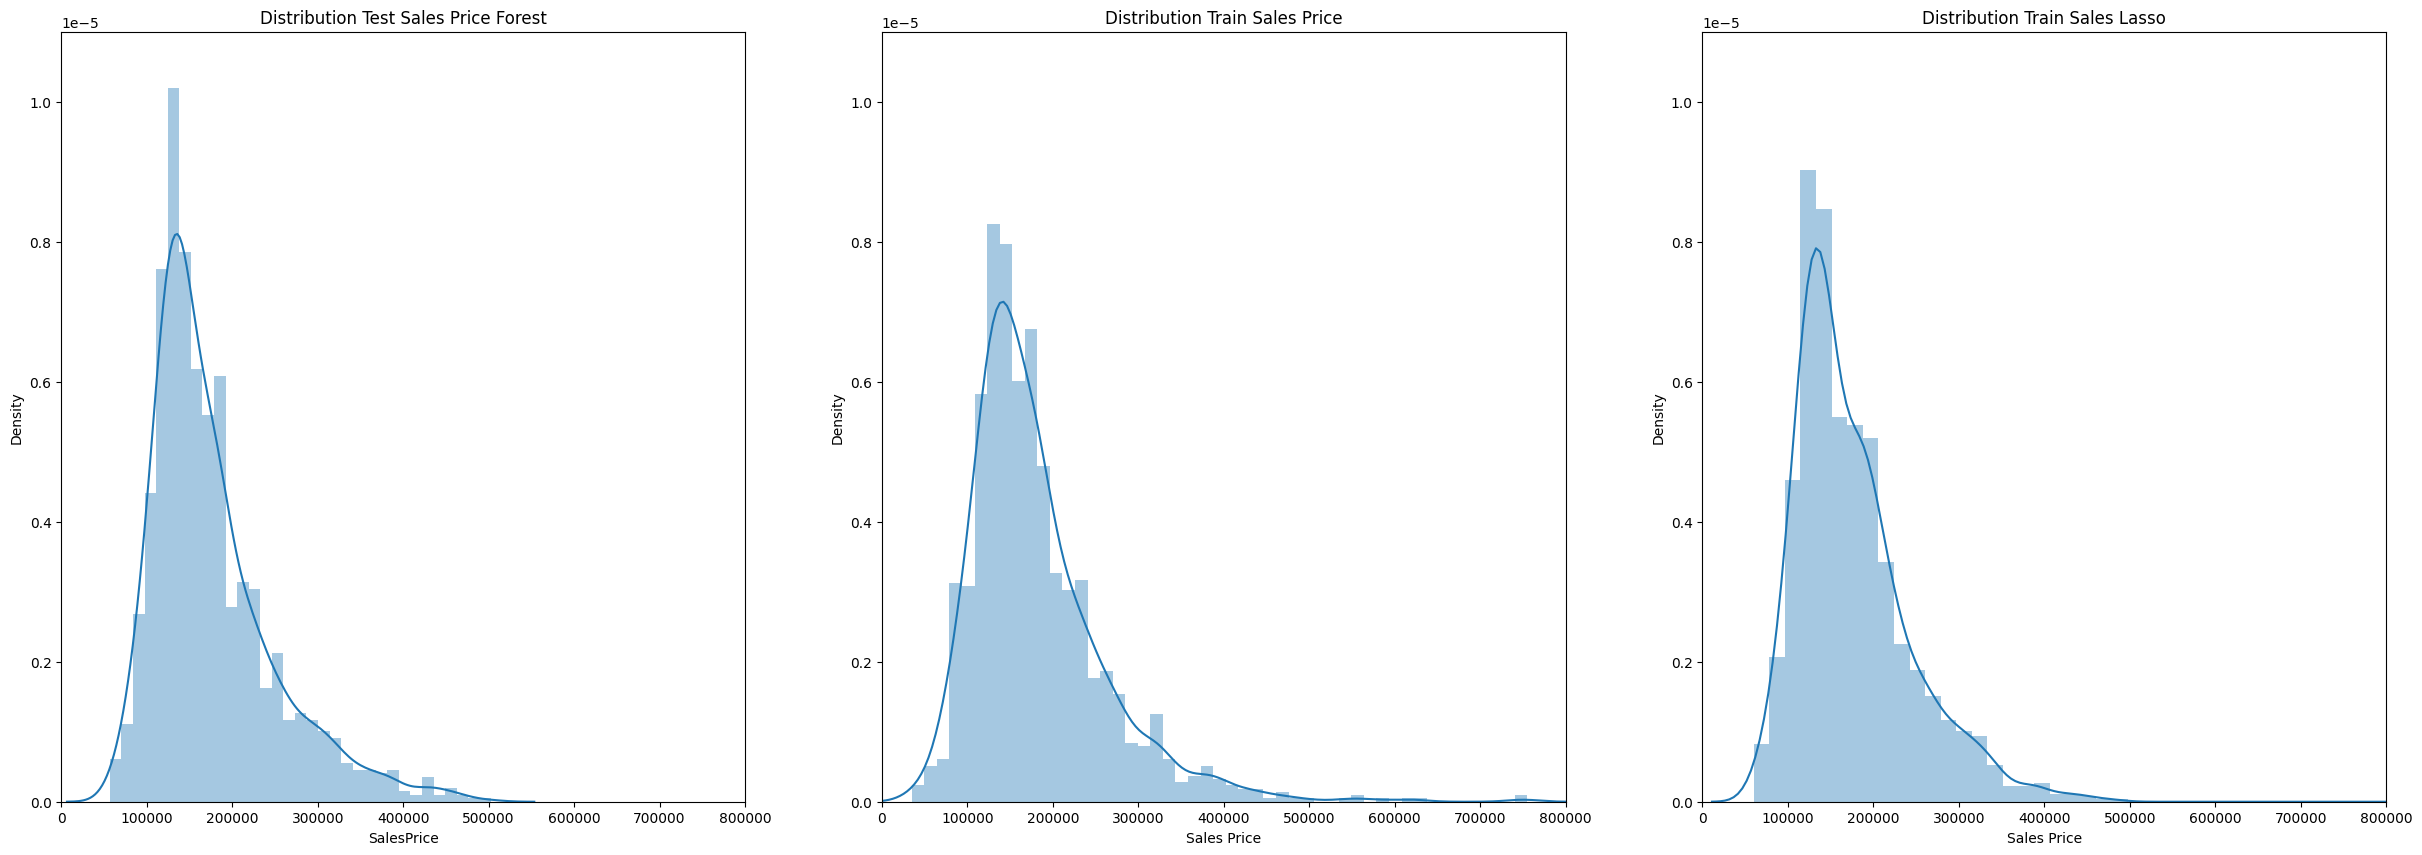

In [ ]:
dist = pd.DataFrame()
fig, axes = plt.subplots(1,3, figsize=(30,10))
sns.distplot(ForestSubmission['SalePrice'], ax=axes[0])
axes[0].set_title('Distribution Test Sales Price Forest')
axes[0].set_xlabel('SalesPrice')
axes[0].set_xlim(0,800000)
axes[0].set_ylim(0,0.000011)
sns.distplot(train['SalePrice'], ax=axes[1])
axes[1].set_title('Distribution Train Sales Price')
axes[1].set_xlabel('Sales Price')
axes[1].set_xlim(0,800000)
axes[1].set_ylim(0,0.000011)
sns.distplot(LassoSubmission['SalePrice'], ax=axes[2])
axes[2].set_title('Distribution Train Sales Lasso')
axes[2].set_xlabel('Sales Price')
axes[2].set_xlim(0,800000)
axes[2].set_ylim(0,0.000011)
plt.show()